In [3]:
%cd /content/drive/MyDrive/데이터사이언스/Gan_Code_Paper

/content/drive/MyDrive/데이터사이언스/Gan_Code_Paper


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import torchvision
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
print(torch.__version__,device)

batch_size=32
epochs=10

train_dataset=datasets.MNIST(root="./data/MNIST",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="./data/MNIST",
                            train=False,
                            transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, # minibatch로 나누는 과정
                                        batch_size=batch_size,# 베치 사이즈 크기 결정
                                        shuffle=False)# 데이터 순서를 섞고자 할 때 진행,

1.9.0+cu111 cuda


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
for (x_train,y_train) in train_loader: # 
  print('x_train:',x_train.size(),'type:',x_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


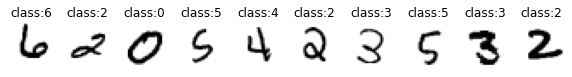

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28),cmap="gray_r")
  plt.title('class:'+str(y_train[i].item()))

In [7]:
params={'nz':100,'img_size':(784)}
class Generator(nn.Module):
  def __init__(self,params):
    super(Generator,self).__init__()
    self.nz=params['nz']
    self.img_size=params['img_size']
    self.generator=nn.Sequential(
        nn.Linear(self.nz,128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.2),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,784),
        nn.Tanh()
    )
  def forward(self,x):
    return self.generator(x)

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.discriminator=nn.Sequential(
        nn.Linear(784,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    x=x.view(x.size(0),-1)
    return self.discriminator(x)

In [9]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
G=Generator(params).to(device)
D=Discriminator().to(device)
D.apply(initialize_weights)
G.apply(initialize_weights)

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [10]:
loss_func=nn.BCELoss()
opt_G=torch.optim.Adam(G.parameters(),lr=0.0001,betas=(0.5,0.999))
opt_D=torch.optim.Adam(D.parameters(),lr=0.0001,betas=(0.5,0.999))

In [26]:
def grid_image(tensor_images, size=10, nrow=5):
  tensor_images = ((tensor_images + 1) / 2 ).clamp(0, 1)
  return torchvision.utils.make_grid(tensor_images[:size], nrow=nrow)

def show_image(tensor_images, size=10, nrow=5,save=None,root=None): # 이미지 출력
  to_pil = transforms.ToPILImage()
  grid_img = grid_image(tensor_images)
  plt.imshow(to_pil(grid_img), interpolation="bicubic")
  if save:
    plt.savefig(root)
def rand_z():
   return torch.randn(32, 100).to(device)

In [12]:
g_loss_graph=[]
d_loss_graph=[]
g_loss_epoch=[]
d_loss_epoch=[]
for epoch in range(100):
  for x_train,y_train in train_loader:
    x_train=x_train.to(device)
    G.zero_grad()
    #real,fake
    y_real=torch.Tensor(32,1).fill_(1.0).to(device)
    y_fake=torch.Tensor(32,1).fill_(0.0).to(device)
    #z
    noise=torch.randn(32,100,device=device)
    #G
    fake_output=G(noise)
    fake_D=D(fake_output)
    loss_G=loss_func(fake_D,y_real)
    loss_G.backward()
    opt_G.step()
    #D
    D.zero_grad()

    real_D=D(x_train)
    fake_D=D(fake_output.detach())
    loss_fake=loss_func(fake_D,y_fake)
    loss_real=loss_func(real_D,y_real)
    loss_D=(loss_fake+loss_real)/2
    loss_D.backward()
    opt_D.step()
    g_loss_graph.append(loss_G)
    d_loss_graph.append(loss_D)
  g_loss_epoch.append(loss_G)
  d_loss_epoch.append(loss_D)
  print("Epoch: %.0f, G_loss: %.6f, D_loss: %.6f"%( epoch, loss_G, loss_D))

Epoch: 0, G_loss: 0.694213, D_loss: 0.697196
Epoch: 1, G_loss: 0.887684, D_loss: 0.668289
Epoch: 2, G_loss: 0.970815, D_loss: 0.476632
Epoch: 3, G_loss: 0.985657, D_loss: 0.533376
Epoch: 4, G_loss: 1.063034, D_loss: 0.484607
Epoch: 5, G_loss: 1.266100, D_loss: 0.456126
Epoch: 6, G_loss: 1.498487, D_loss: 0.454919
Epoch: 7, G_loss: 1.682998, D_loss: 0.312248
Epoch: 8, G_loss: 1.511652, D_loss: 0.530309
Epoch: 9, G_loss: 1.229564, D_loss: 0.417698
Epoch: 10, G_loss: 1.262623, D_loss: 0.383355
Epoch: 11, G_loss: 1.427406, D_loss: 0.375326
Epoch: 12, G_loss: 1.525148, D_loss: 0.447807
Epoch: 13, G_loss: 1.493670, D_loss: 0.433271
Epoch: 14, G_loss: 1.586313, D_loss: 0.277075
Epoch: 15, G_loss: 1.988054, D_loss: 0.203861
Epoch: 16, G_loss: 2.142144, D_loss: 0.347160
Epoch: 17, G_loss: 1.603937, D_loss: 0.340482
Epoch: 18, G_loss: 1.536850, D_loss: 0.445552
Epoch: 19, G_loss: 1.993200, D_loss: 0.428796
Epoch: 20, G_loss: 2.157687, D_loss: 0.216591
Epoch: 21, G_loss: 1.448213, D_loss: 0.43322

In [13]:
# 가중치 저장
import os
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_G.pt')
path2weights_dis = os.path.join(path2models, 'weights_D.pt')

torch.save(G.state_dict(), path2weights_gen)
torch.save(D.state_dict(), path2weights_dis)

In [14]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
G.load_state_dict(weights)

<All keys matched successfully>

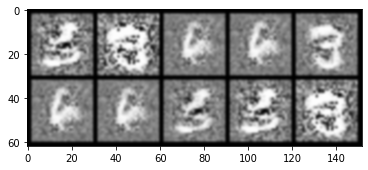

In [27]:
with torch.no_grad():
  z=rand_z()
  fake_images=G(z)
  show_image(fake_images.view(batch_size, 1, 28, 28))

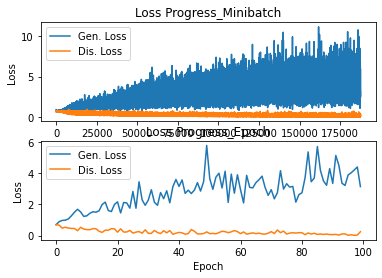

<Figure size 432x288 with 0 Axes>

In [16]:
plt.subplot(2,1,1)
plt.title('Loss Progress_Minibatch')
plt.plot(g_loss_graph, label='Gen. Loss')
plt.plot(d_loss_graph, label='Dis. Loss')
plt.xlabel('Mini_batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.title('Loss Progress_Epoch')
plt.plot(g_loss_epoch, label='Gen. Loss')
plt.plot(d_loss_epoch, label='Dis. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('./assets/Gan_Loss.png')

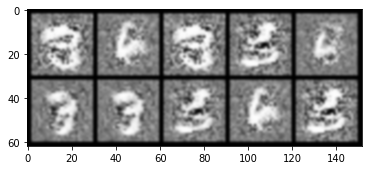

In [17]:
fake_images=G(z)
show_image(fake_images.view(batch_size, 1, 28, 28),save=True,root='./assets/Gan_generate.png')